In [27]:
import os
import numpy as np
import xml.etree.cElementTree as ctree
import random as random
import imgaug as ia
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
%matplotlib inline

sometimes = lambda aug: iaa.Sometimes(0.5, aug)

def augment_image(background, logo_dir):
    logos = [image for image in list(os.listdir(logo_dir))]
    
    logo = random.choice(list(logos))
    
    class_name = logo
    
    logo = "{0}/{1}".format(logo_dir, logo)
    logo = Image.open(logo)
    
    randomized_logo_size = random.randrange(60, 200, 1) 
    
    logo = logo.resize((randomized_logo_size,randomized_logo_size))
    logo = np.array(logo)
    
    # augment logo image
    seq = iaa.Sequential([
        iaa.GaussianBlur(sigma=(0, 2.0)),
        iaa.Multiply((0.85, 1.5)), # change brightness, doesn't affect BBs
        iaa.Affine(
            scale={"x": (0.5, 1), "y": (0.5, 1)},
            rotate=(-25, 25),
            shear=(-8, 8)
        ),
    ], random_order=True)

    aug_logo = seq.augment_images([logo])[0]
    
    logo = Image.fromarray(aug_logo)
    
    bbox = logo.getbbox()
    logo = logo.crop(bbox)
    
    image_w, image_h  = logo.size
    
    background_h, background_w = background.size
    
    position_constrained_x = background_w - image_w
    position_constrained_y = background_h - image_h

    x = random.randrange(0, position_constrained_x, 1)
    y = random.randrange(0, position_constrained_y, 1)

    background.paste(logo, (x,y), logo)
    
    return background, [class_name, (x, y, x+image_w, y+image_h)]
    
def load_image(logo_dir, background_dir, number_augmented_images=1):
    
    backgrounds = [image  for image in list(os.listdir(background_dir))]
    background = random.choice(list(backgrounds)) 
    background = "{0}/{1}".format(background_dir, background)
    background = Image.open(background).convert('RGBA')
    background = background.resize((416,416))
    background = np.array(background)
    background = Image.fromarray(background.astype('uint8'), 'RGBA') 
    
    bounding_boxes = []
    
    image = background
    for i in list(range(number_augmented_images)):
        data = augment_image(image, logo_dir)
        
        image = data[0]
        bounding_boxes.append(data[1])
    return image, bounding_boxes

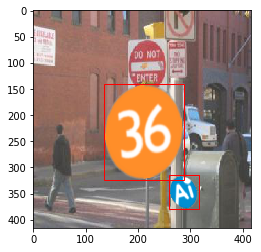

In [28]:
data = load_image("images/logos", "images/ICCV09DATA", 2)

bounding_boxes = data[1]

fig,ax = plt.subplots(1)
# Display the image
ax.imshow(data[0])

for bounding_box in bounding_boxes:
    
    coordinates = bounding_box[1]
    
    x = coordinates[0]
    y = coordinates[1]
    width = coordinates[2]-coordinates[0]
    height = coordinates[3]-coordinates[1]
    
    rect = patches.Rectangle((x,y), width=width, height=height, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()



In [19]:
for i in list(range(1, 3000)):
    data = load_image("images/logos", "images/ICCV09DATA", 1)
    
    image = data[0].convert('RGB')
    image_filename = "JPEGImages/{0}.jpg".format(i)
    image.save(image_filename)
    
    annotation = ctree.Element("annotation")
    filename = ctree.SubElement(annotation, "filename").text = "{0}".format(i)
    size = ctree.SubElement(annotation, "size")
    ctree.SubElement(size, "width").text = "416"
    ctree.SubElement(size, "height").text = "416"
    ctree.SubElement(size, "depth").text = "3"

    bounding_boxes = data[1]
    for bounding_box in bounding_boxes:
        class_name = bounding_box[0]
        coordinates = bounding_box[1]
        
        obj = ctree.SubElement(annotation, "object")
        name = ctree.SubElement(obj, "name").text = class_name.split(".")[0]
        bndbox = ctree.SubElement(obj, "bndbox")
        xmin = ctree.SubElement(bndbox, "xmin").text = str(coordinates[0])
        ymin = ctree.SubElement(bndbox, "ymin").text = str(coordinates[1])
        xmax = ctree.SubElement(bndbox, "xmax").text = str(coordinates[2])
        ymax = ctree.SubElement(bndbox, "ymax").text = str(coordinates[3])

    tree = ctree.ElementTree(annotation)
    
    annotation_filename = "Annotations/{0}.xml".format(i)
    tree.write(annotation_filename)

KeyboardInterrupt: 